In [25]:
# this code is written by Changyi Yang used for DS Discovery program

import torch.nn as nn
import torch
from torch.utils.data import Dataset, DataLoader
import torch.optim as optim

import pandas as pd

import numpy as np

import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.decomposition import  PCA

In [2]:
torch. __version__

'1.13.0+cpu'

In [3]:
# from google.colab import drive
# drive.mount('/content/drive', force_remount=True)
# %cd /content/drive/Shareddrives/PebbleReactorProject/Data

In [4]:
# define the dataset classes


class ReactorData(Dataset):
    def __init__(self,file_name, sequence_length, start_percent = 0, end_percent = 1):
        data = pd.read_csv(file_name, skiprows=[0]) # skip the first line
        
        length = data.shape[0]
        data = data[ int(length * start_percent)  : int(length * end_percent)]
        
        # print(data.shape)
        
        self.labels = data.iloc[:, -1:]
        self.data = data.iloc[:, 1:-1] # skip the first time column
        
        mm = MinMaxScaler()
        ss = StandardScaler()


        self.data = ss.fit_transform(self.data)
        self.labels = mm.fit_transform(self.labels) 
        
        self.sequence_length = sequence_length
        
    def __len__(self):
        return len(self.labels)//self.sequence_length
    
    def __getitem__(self,idx):
        idx = idx * self.sequence_length
        
        return (torch.tensor(self.data[idx : idx+ self.sequence_length])).double(), \
    (torch.tensor(self.labels[idx : idx+ self.sequence_length])).double()

        

In [58]:
# load the data
sequence_length = 20

training_data = ReactorData('data_PBMR_400.csv', sequence_length= sequence_length, start_percent= 0, end_percent= 0.75)
testing_data = ReactorData('data_PBMR_400.csv', sequence_length= sequence_length, start_percent= 0.75, end_percent= 1)


In [60]:
print(testing_data.data.shape)

(59, 40040)


(175, 40040)
(175,)


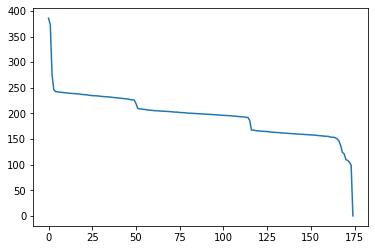

In [21]:
# do some data analysis for the PCA part

# for the full matrix
data= training_data.data

# do the svd
U, S, VT = np.linalg.svd(data, full_matrices= False)

print(data.shape)
print(S.shape)

plt.plot(S)




[235.43990581 207.03675649 205.90545803 205.73807536 204.95511792
 204.84637408 204.46091601 203.42501097 203.32649844 202.96540559
 202.55523515 202.10080058 201.28551497 200.84419885 200.13295248
 199.58501246 199.17200203 198.18087649 189.06640905 163.55811479]


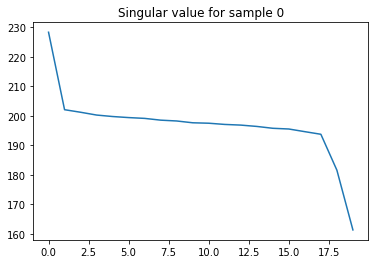

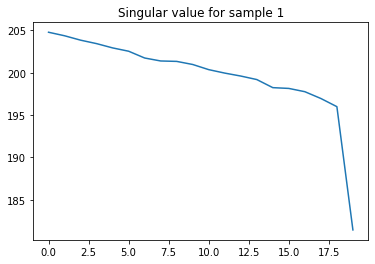

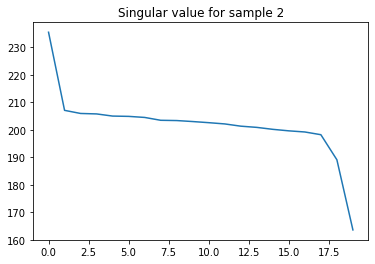

In [23]:
# for the full matrix
for i in range(3):
    data, _ = training_data[i]

    # do the svd
    U, S, VT = np.linalg.svd(data, full_matrices= False)

    # print(data.shape)
    # print(S.shape)

    plt.figure()
    plt.plot(S)
    plt.title(f"Singular value for sample {i}")

print(S)


(175, 175)


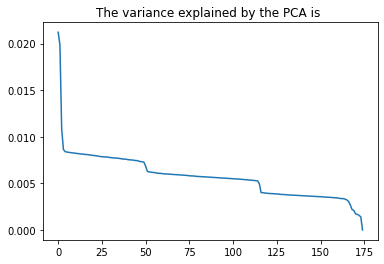

In [31]:
# try doing PCA with sklearn

pca = PCA()

data = pca.fit_transform(training_data.data)

print(data.shape)
plt.title('The variance explained by the PCA is ')
plt.plot(pca.explained_variance_ratio_)

In [63]:
# the dataset with PCA
class ReactorDatawithPCA(Dataset):
    def __init__(self,file_name, sequence_length, start_percent = 0, end_percent = 1, n_components = 100):
        data = pd.read_csv(file_name, skiprows=[0]) # skip the first line
        
        length = data.shape[0]
        data = data[ int(length * start_percent)  : int(length * end_percent)]
        
        # print(data.shape)
        
        self.labels = data.iloc[:, -1:]
        self.data = data.iloc[:, 1:-1] # skip the first time column
        
        mm = MinMaxScaler()
        ss = StandardScaler()


        # pca then normalize
        pca = PCA(n_components= n_components, svd_solver= 'auto')
        self.data = pca.fit_transform(self.data)
        self.data = ss.fit_transform(self.data)
        
        self.labels = mm.fit_transform(self.labels) 
        
        
        
        
        self.sequence_length = sequence_length
        
    def __len__(self):
        return len(self.labels)//self.sequence_length
    
    def __getitem__(self,idx):
        idx = idx * self.sequence_length
        
        return (torch.tensor(self.data[idx : idx+ self.sequence_length])).double(), \
    (torch.tensor(self.labels[idx : idx+ self.sequence_length])).double()


In [71]:
sequence_length = 20
n_components = 30
training_data_PCA = ReactorDatawithPCA('data_PBMR_400.csv', sequence_length= sequence_length, start_percent= 0, end_percent= 0.75, n_components= n_components)
testing_data_PCA = ReactorDatawithPCA('data_PBMR_400.csv', sequence_length= sequence_length, start_percent= 0.75, end_percent= 1, n_components= n_components)

# n_components must be between 1 and min(n_samples, n_features)=59 with svd_solver='randomized'

In [72]:
# define the neural nets
class SimpleLSTM(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim, lstm_nums_layer, dropout):
        super().__init__()
        self.input_dim = input_dim
        self.hidden_dim = hidden_dim
        self.output_dim = output_dim
        
        
        self.LSTM = nn.LSTM(input_dim, hidden_dim, lstm_nums_layer, batch_first = True)
        self.dropout = nn.Dropout(dropout)
        
        self.hidden_to_output = nn.Linear(hidden_dim, output_dim)
        
    def forward(self, input):
        # print(input.shape)
        
        hidden_state, _ = self.LSTM(input)
        
        # print(hidden_state.shape)
        output = self.dropout(hidden_state)
        output = self.hidden_to_output(output)
        
        
        return output
    
    


In [73]:
# train the model

training_data = training_data_PCA
testing_data = testing_data_PCA


input_dim = training_data[0][0].shape[1]
output_dim = training_data[0][1].shape[1]


# print(output_dim)

# some adjustable hyper-parameters
hidden_dim = 128
num_hidden_layers = 2
batch_size = 5
learning_rate = 1e-3
weight_decay = 1e-4
epoch_num = 400
dropout = 0.2

model = SimpleLSTM(input_dim, hidden_dim, output_dim, num_hidden_layers, dropout)
model = model.double()

train_dataloader = DataLoader(training_data, batch_size = batch_size)


# the chosn loss function and optimizer
loss_fn = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr = learning_rate, weight_decay= weight_decay)



for epoch in range(epoch_num):
    
    for batch, (X, y) in enumerate(train_dataloader):
        

        
        model.zero_grad()
        
        pred = model(X)
        
        # print(X.shape)
        # print(y.shape)
        
        loss = loss_fn(pred, y)
        
        # backpropagation
        
        loss.backward()
        optimizer.step()
        
        loss = loss.item()
        
    if epoch % 20 == 0:
        print("The loss is {} in epoch {}".format(loss ,epoch))
            

print(f"The training is ended, the final loss is {loss}.")
print("Bye")

The loss is 0.16354675309472935 in epoch 0
The loss is 0.018631140704910985 in epoch 20
The loss is 0.013320493520158861 in epoch 40
The loss is 0.007621094246345197 in epoch 60
The loss is 0.004599874147183715 in epoch 80
The loss is 0.003178917374618058 in epoch 100
The loss is 0.0024609086823595932 in epoch 120
The loss is 0.001851053644744186 in epoch 140
The loss is 0.0011384107820000754 in epoch 160
The loss is 0.0011029690498220884 in epoch 180
The loss is 0.0005992572853150495 in epoch 200
The loss is 0.0010562312925305984 in epoch 220
The loss is 0.00045264438684984473 in epoch 240
The loss is 0.0004499899081431981 in epoch 260
The loss is 0.000577031412908692 in epoch 280
The loss is 0.0003794018567883291 in epoch 300
The loss is 0.0006098893149514306 in epoch 320
The loss is 0.0007877232733131144 in epoch 340
The loss is 0.0006820036613663298 in epoch 360
The loss is 0.0004574361609276429 in epoch 380
The training is ended, the final loss is 0.0004576769482043348.
Bye


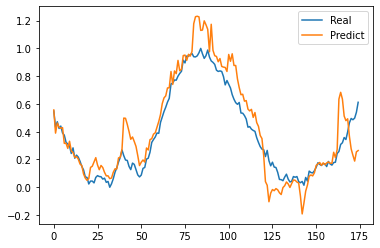

In [74]:
# visualize the training output




X_train = (torch.tensor(training_data.data)).double()
y_train = (torch.tensor(training_data.labels)).double()


plt.figure()
plt.plot(y_train, label = "Real")     
plt.plot(model(X_train).detach().numpy(), label = "Predict")
plt.legend()


In [75]:
X_test = (torch.tensor(testing_data.data)).double()
y_test = (torch.tensor(testing_data.labels)).double()

print(X_test.shape)

torch.Size([59, 30])


The test loss is 0.41654417125753845


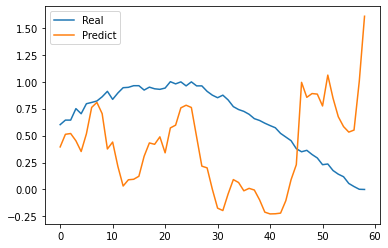

In [76]:
# visualize the test output

import matplotlib.pyplot as plt


X_test = (torch.tensor(testing_data.data)).double()
y_test = (torch.tensor(testing_data.labels)).double()

y_pred = model(X_test)

loss = nn.MSELoss()
print(f"The test loss is {loss(y_pred, y_test).item()}")

plt.figure()
plt.plot(y_test, label = "Real")     
plt.plot(y_pred.detach().numpy(), label = "Predict")
plt.legend()